# Import Libraries

In [1]:
# Pandas & Numpy 
import pandas as pd 
import numpy as np 

# Suprise & Recommenders 
import surprise 
from recommenders.models.surprise.surprise_utils import compute_ranking_predictions, predict
from recommenders.evaluation.python_evaluation import precision_at_k, recall_at_k

# Reading Data

In [2]:
# Read Train & Test Data
train = pd.read_csv("../../00_Data/online_retail_train_mixed.csv", index_col=0)
test = pd.read_csv("../../00_Data/online_retail_test_mixed.csv", index_col=0)

In [3]:
# Check Shapes
print("Shape of Train:", train.shape)
print("Shape of Test: \t", test.shape)

Shape of Train: (287957, 3)
Shape of Test: 	 (71990, 3)


# Data Preparation: Value of Purchase

In [27]:
# Change values of purchased to 5
#train['purchased'] = 1
#test['purchased'] = 1

In [4]:
# Sanity Check with Describe 
train.purchased.describe()

count    287957.000000
mean          0.720524
std           0.448742
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: purchased, dtype: float64

# Preparation of Train Dataset for Surprise Models



In [5]:
# Reader 
reader = surprise.Reader(rating_scale=(0,1))

# Build Train Set from Custom Dataset
train_set = surprise.Dataset.load_from_df(train[['CustomerID', 'StockCode', 'purchased']], reader=reader).build_full_trainset()

# Baseline Model

In [6]:
# Delete Model first 
try:
    del(basemodel)
except:
    pass

# Create Object for Model
basemodel = surprise.NMF(random_state=0, verbose=False, n_factors=10, n_epochs=50, reg_pu=0.1, reg_qi=0.1)

# Fit Model
basemodel.fit(train_set)

# Prediction: Test Set only

In [7]:
# Predict Test Only
test_pred = predict(basemodel, test, usercol='CustomerID', itemcol='StockCode')

In [8]:
# Check Range of predicions
test_pred.prediction.describe()

count    71990.000000
mean         0.627049
std          0.203495
min          0.041243
25%          0.482661
50%          0.660721
75%          0.788605
max          1.000000
Name: prediction, dtype: float64

In [9]:
# Convert Predictions
test_pred['prediction'] = np.where((test_pred['prediction']>0.5), 1,0)

In [10]:
# Check Distribution
test_pred['prediction'].value_counts()

1    52453
0    19537
Name: prediction, dtype: int64

In [11]:
# Sort Index of both Datasets to use Accuracy Score 
test = test.sort_values(by=['CustomerID', 'StockCode'])
test_pred = test_pred.sort_values(by=['CustomerID', 'StockCode'])

# Reset indeces for both DataFrames
test = test.reset_index(drop=True)
test_pred = test_pred.reset_index(drop=True)

In [12]:
# First Reorder columns for test 
test = test[['CustomerID', 'StockCode', 'purchased']]
# Head of Test
test.head()

,CustomerID,StockCode,purchased
0,1,87,1
1,1,206,1
2,1,275,1
3,1,316,1
4,1,395,0


In [13]:
# Head of Test_pred - Compare Index with test.head() above 
test_pred.head()

,CustomerID,StockCode,prediction
0,1,87,0
1,1,206,0
2,1,275,0
3,1,316,1
4,1,395,1


In [39]:
# Import Accuracy 
from sklearn.metrics import accuracy_score

# Accuracy all instances 
accuracy_score(test.purchased, test_pred.prediction)

ValueError: Found input variables with inconsistent numbers of samples: [51870, 71990]

In [40]:
# Accuracy on positive Test only
test_positive = test[test['purchased']==1]
test_positive_pred = test_positive.merge(test_pred, on=['CustomerID', 'StockCode'], how='left', indicator=True)
test_positive_pred.purchased.value_counts()
# Accuracy 
accuracy_score(test_positive_pred.purchased, test_positive_pred.prediction)


0.8564680933101986

# Prediction: Top N

In [15]:
# Predict All Pairs of Users & Items that are NOT in the Trainset 
predictions = compute_ranking_predictions(basemodel, train, usercol='CustomerID', itemcol='StockCode', remove_seen=True)

In [16]:
# Check first five rows
predictions.head()

,CustomerID,StockCode,prediction
287957,1620,1917,0.618312
287958,1620,673,0.184092
287959,1620,2369,0.559933
287960,1620,2855,0.683404
287961,1620,386,0.615137


In [17]:
# Filter Test for purchased items only
test = test[test['purchased']==1]

In [18]:
# Write function to filter out top N 
def filter_top_n(predictions: pd.DataFrame, n: int) -> pd.DataFrame:
    
    # Group the dataframe by 'CustomerID', and for each group, sort by 'prediction' in descending order, then take the top N rows
    top_n_per_customer = predictions.groupby('CustomerID', group_keys=False).apply(lambda group: group.sort_values('prediction', ascending=False).head(n))
    
    return top_n_per_customer

# Filter Top 10 
top_10 = filter_top_n(predictions, 10)

# Filter Top 20 
top_20 = filter_top_n(predictions, 20)

In [19]:
# Evaluate Precision at 10 
eval_precision_10 = precision_at_k(test, top_10, col_user="CustomerID", col_item="StockCode",
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=10)
print('precision at 10 \t:', eval_precision_10)

# Evaluate Recall at 10 
eval_recall_10 = recall_at_k(test, top_10,col_user="CustomerID", col_item="StockCode",
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=10)
print('recall at 10 \t:', eval_recall_10)

precision at 10 	: 0.04501369863013698
recall at 10 	: 0.038550527459455156


In [20]:
# Evaluate Precision at 20 
eval_precision_20 = precision_at_k(test, top_20, col_user="CustomerID", col_item="StockCode",
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=20)
print('precision at 20 \t:', eval_precision_20)

# Evaluate Recall at 20 
eval_recall_20 = recall_at_k(test, top_20,col_user="CustomerID", col_item="StockCode",
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=20)
print('recall at 20 \t:', eval_recall_20)

precision at 20 	: 0.03963013698630138
recall at 20 	: 0.06420812363139447


# Hyperparameter Tuning

In [25]:
# Define Set of Hyperparameters 
n_factors = [5, 10, 15, 20, 100]
biases = [False, True]
reg_all = [0.01, 0.02]
lr_det = [0.001, 0.005]

# Initiate Lists 
factor_nr = []
regulation_all = []
lr_all = []
bias_all = []
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []

for factors in n_factors:
    for regulation in reg_all:
        for learning in lr_det:
            for bias in biases:
                try:
                    del(model)
                except:
                    pass 
                # Define Model 
                model = surprise.NMF(random_state=0,
                                    verbose=False,
                                    biased=False,
                                    n_factors=factors,
                                    n_epochs=50,
                                    reg_bi=regulation,
                                    reg_bu=regulation,
                                    lr_bi=learning,
                                    lr_bu=learning)
                
                # Fit model
                model.fit(train_set)
                
                # Predict All Pairs of Users & Items that are NOT in the Trainset 
                predictions = compute_ranking_predictions(model, test, usercol='CustomerID', itemcol='StockCode')
                
                # Filter Top 10 & 20 
                top_10 = filter_top_n(predictions, 10)
                top_20 = filter_top_n(predictions, 20)
                
                # Evaluate Recall at 10 
                eval_recall_10 = recall_at_k(test, top_10,col_user="CustomerID", col_item="StockCode",
                                            col_rating="purchased", col_prediction="prediction", 
                                            relevancy_method="top_k", k=10)
                # Evaluate Recall at 20 
                eval_recall_20 = recall_at_k(test, top_20,col_user="CustomerID", col_item="StockCode",
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=20)
                
                # Evaluate Precision at 10 
                eval_precision_10 = precision_at_k(test, top_10, col_user="CustomerID", col_item="StockCode",
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=10)
                # Evaluate Precision at 20 
                eval_precision_20 = precision_at_k(test, top_20, col_user="CustomerID", col_item="StockCode",
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=20) 
                
                print("recall at for", factors, "factors: \t", eval_recall_10)
                factor_nr.append(factors)
                regulation_all.append(regulation)
                lr_all.append(learning)
                bias_all.append(bias)
                recall_10.append(eval_recall_10)
                recall_20.append(eval_recall_20)
                precision_10.append(eval_precision_10)
                precision_20.append(eval_precision_20)
                

recall at for 5 factors: 	 0.031565478954756504
recall at for 5 factors: 	 0.031565478954756504
recall at for 5 factors: 	 0.031565478954756504
recall at for 5 factors: 	 0.031565478954756504
recall at for 5 factors: 	 0.031565478954756504
recall at for 5 factors: 	 0.031565478954756504
recall at for 5 factors: 	 0.031565478954756504
recall at for 5 factors: 	 0.031565478954756504
recall at for 10 factors: 	 0.03470695985782015
recall at for 10 factors: 	 0.03470695985782015
recall at for 10 factors: 	 0.03470695985782015
recall at for 10 factors: 	 0.03470695985782015
recall at for 10 factors: 	 0.03470695985782015
recall at for 10 factors: 	 0.03470695985782015
recall at for 10 factors: 	 0.03470695985782015
recall at for 10 factors: 	 0.03470695985782015
recall at for 15 factors: 	 0.035963950914998356
recall at for 15 factors: 	 0.035963950914998356
recall at for 15 factors: 	 0.035963950914998356
recall at for 15 factors: 	 0.035963950914998356
recall at for 15 factors: 	 0.035963

In [27]:
dict_param = {
    "factor": factor_nr,
    "regulation_all": regulation_all,
    "learning_rate_all": lr_all,
    "bias" : bias_all,
    "recall_10": recall_10,
    "recall_20": recall_20,
    "precision_10" : precision_10,
    "precision_20" : precision_20
}

In [28]:
df_param = pd.DataFrame(dict_param)
df_param.head()

,factor,regulation_all,learning_rate_all,bias,recall_10,recall_20,precision_10,precision_20
0,5,0.01,0.001,False,0.031565,0.054856,0.034356,0.031877
1,5,0.01,0.001,True,0.031565,0.054856,0.034356,0.031877
2,5,0.01,0.005,False,0.031565,0.054856,0.034356,0.031877
3,5,0.01,0.005,True,0.031565,0.054856,0.034356,0.031877
4,5,0.02,0.001,False,0.031565,0.054856,0.034356,0.031877


In [42]:
df_param.head(10)

,factor,regulation_all,learning_rate_all,bias,recall_10,recall_20,precision_10,precision_20
0,5,0.01,0.001,False,0.031565,0.054856,0.034356,0.031877
1,5,0.01,0.001,True,0.031565,0.054856,0.034356,0.031877
2,5,0.01,0.005,False,0.031565,0.054856,0.034356,0.031877
3,5,0.01,0.005,True,0.031565,0.054856,0.034356,0.031877
4,5,0.02,0.001,False,0.031565,0.054856,0.034356,0.031877
5,5,0.02,0.001,True,0.031565,0.054856,0.034356,0.031877
6,5,0.02,0.005,False,0.031565,0.054856,0.034356,0.031877
7,5,0.02,0.005,True,0.031565,0.054856,0.034356,0.031877
8,10,0.01,0.001,False,0.034707,0.059088,0.036548,0.033342
9,10,0.01,0.001,True,0.034707,0.059088,0.036548,0.033342


# Tuning 2 

In [30]:
# Define Set of Hyperparameters 
n_factors = [50, 100, 150]
reg_all = [0.01]
lr_det = [0.001]

# Initiate Lists 
factor_nr = []
regulation_all = []
lr_all = []
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []

for factors in n_factors:
    for regulation in reg_all:
        for learning in lr_det:
            try:
                del(model)
            except:
                pass 
            # Define Model 
            model = surprise.NMF(random_state=0,
                                verbose=False,
                                biased=False,
                                n_factors=factors,
                                n_epochs=50,
                                reg_bi=regulation,
                                reg_bu=regulation,
                                lr_bi=learning,
                                lr_bu=learning)
            
            # Fit model
            model.fit(train_set)
            
            # Predict All Pairs of Users & Items that are NOT in the Trainset 
            predictions = compute_ranking_predictions(model, test, usercol='CustomerID', itemcol='StockCode')
            
            # Filter Top 10 & 20 
            top_10 = filter_top_n(predictions, 10)
            top_20 = filter_top_n(predictions, 20)
            
            # Evaluate Recall at 10 
            eval_recall_10 = recall_at_k(test, top_10,col_user="CustomerID", col_item="StockCode",
                                        col_rating="purchased", col_prediction="prediction", 
                                        relevancy_method="top_k", k=10)
            # Evaluate Recall at 20 
            eval_recall_20 = recall_at_k(test, top_20,col_user="CustomerID", col_item="StockCode",
                                col_rating="purchased", col_prediction="prediction", 
                                relevancy_method="top_k", k=20)
            
            # Evaluate Precision at 10 
            eval_precision_10 = precision_at_k(test, top_10, col_user="CustomerID", col_item="StockCode",
                                col_rating="purchased", col_prediction="prediction", 
                                relevancy_method="top_k", k=10)
            # Evaluate Precision at 20 
            eval_precision_20 = precision_at_k(test, top_20, col_user="CustomerID", col_item="StockCode",
                                col_rating="purchased", col_prediction="prediction", 
                                relevancy_method="top_k", k=20) 
            
            print("recall at for", factors, "factors: \t", eval_recall_10)
            factor_nr.append(factors)
            regulation_all.append(regulation)
            lr_all.append(learning)
            recall_10.append(eval_recall_10)
            recall_20.append(eval_recall_20)
            precision_10.append(eval_precision_10)
            precision_20.append(eval_precision_20)
            

recall at for 50 factors: 	 0.04635509778682828
recall at for 100 factors: 	 0.04833160474224164
recall at for 150 factors: 	 0.04795210567921304


In [32]:
dict_param2 = {
    "factor": factor_nr,
    "regulation_all": regulation_all,
    "learning_rate_all": lr_all,
    "recall_10": recall_10,
    "recall_20": recall_20,
    "precision_10" : precision_10,
    "precision_20" : precision_20
}

df_param2 = pd.DataFrame(dict_param2)
df_param2.head()

,factor,regulation_all,learning_rate_all,recall_10,recall_20,precision_10,precision_20
0,50,0.01,0.001,0.046355,0.080950,0.044055,0.039973
1,100,0.01,0.001,0.048332,0.083032,0.045041,0.040205
2,150,0.01,0.001,0.047952,0.082213,0.045041,0.040740


# Tuning 3

In [33]:
# Define Set of Hyperparameters 
n_factors = [80, 90, 100, 110, 120]
reg_all = [0.01]
lr_det = [0.001]

# Initiate Lists 
factor_nr = []
regulation_all = []
lr_all = []
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []

for factors in n_factors:
    for regulation in reg_all:
        for learning in lr_det:
            try:
                del(model)
            except:
                pass 
            # Define Model 
            model = surprise.NMF(random_state=0,
                                verbose=False,
                                biased=False,
                                n_factors=factors,
                                n_epochs=50,
                                reg_bi=regulation,
                                reg_bu=regulation,
                                lr_bi=learning,
                                lr_bu=learning)
            
            # Fit model
            model.fit(train_set)
            
            # Predict All Pairs of Users & Items that are NOT in the Trainset 
            predictions = compute_ranking_predictions(model, test, usercol='CustomerID', itemcol='StockCode')
            
            # Filter Top 10 & 20 
            top_10 = filter_top_n(predictions, 10)
            top_20 = filter_top_n(predictions, 20)
            
            # Evaluate Recall at 10 
            eval_recall_10 = recall_at_k(test, top_10,col_user="CustomerID", col_item="StockCode",
                                        col_rating="purchased", col_prediction="prediction", 
                                        relevancy_method="top_k", k=10)
            # Evaluate Recall at 20 
            eval_recall_20 = recall_at_k(test, top_20,col_user="CustomerID", col_item="StockCode",
                                col_rating="purchased", col_prediction="prediction", 
                                relevancy_method="top_k", k=20)
            
            # Evaluate Precision at 10 
            eval_precision_10 = precision_at_k(test, top_10, col_user="CustomerID", col_item="StockCode",
                                col_rating="purchased", col_prediction="prediction", 
                                relevancy_method="top_k", k=10)
            # Evaluate Precision at 20 
            eval_precision_20 = precision_at_k(test, top_20, col_user="CustomerID", col_item="StockCode",
                                col_rating="purchased", col_prediction="prediction", 
                                relevancy_method="top_k", k=20) 
            
            print("recall at for", factors, "factors: \t", eval_recall_10)
            factor_nr.append(factors)
            regulation_all.append(regulation)
            lr_all.append(learning)
            recall_10.append(eval_recall_10)
            recall_20.append(eval_recall_20)
            precision_10.append(eval_precision_10)
            precision_20.append(eval_precision_20)

recall at for 80 factors: 	 0.04909649230322121
recall at for 90 factors: 	 0.0500028071259704
recall at for 100 factors: 	 0.04833160474224164
recall at for 110 factors: 	 0.04795280279856533
recall at for 120 factors: 	 0.0501874973782127


In [34]:
dict_param3 = {
    "factor": factor_nr,
    "regulation_all": regulation_all,
    "learning_rate_all": lr_all,
    "recall_10": recall_10,
    "recall_20": recall_20,
    "precision_10" : precision_10,
    "precision_20" : precision_20
}

df_param3 = pd.DataFrame(dict_param3)
df_param3.head()

,factor,regulation_all,learning_rate_all,recall_10,recall_20,precision_10,precision_20
0,80,0.01,0.001,0.049096,0.085181,0.044795,0.041288
1,90,0.01,0.001,0.050003,0.085124,0.046301,0.041493
2,100,0.01,0.001,0.048332,0.083032,0.045041,0.040205
3,110,0.01,0.001,0.047953,0.079589,0.044740,0.039041
4,120,0.01,0.001,0.050187,0.085373,0.045178,0.040411


# Tuning 4

In [37]:
# Define Set of Hyperparameters 
n_factors = [116, 117, 118, 119, 120, 121, 122, 123, 124]
reg_all = [0.01]
lr_det = [0.001]

# Initiate Lists 
factor_nr = []
regulation_all = []
lr_all = []
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []

for factors in n_factors:
    for regulation in reg_all:
        for learning in lr_det:
            try:
                del(model)
            except:
                pass 
            # Define Model 
            model = surprise.NMF(random_state=0,
                                verbose=False,
                                biased=False,
                                n_factors=factors,
                                n_epochs=50,
                                reg_bi=regulation,
                                reg_bu=regulation,
                                lr_bi=learning,
                                lr_bu=learning)
            
            # Fit model
            model.fit(train_set)
            
            # Predict All Pairs of Users & Items that are NOT in the Trainset 
            predictions = compute_ranking_predictions(model, test, usercol='CustomerID', itemcol='StockCode')
            
            # Filter Top 10 & 20 
            top_10 = filter_top_n(predictions, 10)
            top_20 = filter_top_n(predictions, 20)
            
            # Evaluate Recall at 10 
            eval_recall_10 = recall_at_k(test, top_10,col_user="CustomerID", col_item="StockCode",
                                        col_rating="purchased", col_prediction="prediction", 
                                        relevancy_method="top_k", k=10)
            # Evaluate Recall at 20 
            eval_recall_20 = recall_at_k(test, top_20,col_user="CustomerID", col_item="StockCode",
                                col_rating="purchased", col_prediction="prediction", 
                                relevancy_method="top_k", k=20)
            
            # Evaluate Precision at 10 
            eval_precision_10 = precision_at_k(test, top_10, col_user="CustomerID", col_item="StockCode",
                                col_rating="purchased", col_prediction="prediction", 
                                relevancy_method="top_k", k=10)
            # Evaluate Precision at 20 
            eval_precision_20 = precision_at_k(test, top_20, col_user="CustomerID", col_item="StockCode",
                                col_rating="purchased", col_prediction="prediction", 
                                relevancy_method="top_k", k=20) 
            
            print("recall at for", factors, "factors: \t", eval_recall_10)
            factor_nr.append(factors)
            regulation_all.append(regulation)
            lr_all.append(learning)
            recall_10.append(eval_recall_10)
            recall_20.append(eval_recall_20)
            precision_10.append(eval_precision_10)
            precision_20.append(eval_precision_20)

recall at for 116 factors: 	 0.04982847684366155
recall at for 117 factors: 	 0.04732298434606868
recall at for 118 factors: 	 0.04708715084830919
recall at for 119 factors: 	 0.047852109483868616
recall at for 120 factors: 	 0.0501874973782127
recall at for 121 factors: 	 0.04834904054833954
recall at for 122 factors: 	 0.04799425394460028
recall at for 123 factors: 	 0.04902805542786527
recall at for 124 factors: 	 0.04912362688624034


In [38]:
dict_param4 = {
    "factor": factor_nr,
    "regulation_all": regulation_all,
    "learning_rate_all": lr_all,
    "recall_10": recall_10,
    "recall_20": recall_20,
    "precision_10" : precision_10,
    "precision_20" : precision_20
}

df_param4 = pd.DataFrame(dict_param4)
df_param4.head()

,factor,regulation_all,learning_rate_all,recall_10,recall_20,precision_10,precision_20
0,116,0.01,0.001,0.049828,0.086099,0.044685,0.041096
1,117,0.01,0.001,0.047323,0.081633,0.044630,0.040438
2,118,0.01,0.001,0.047087,0.083439,0.044575,0.040425
3,119,0.01,0.001,0.047852,0.082937,0.045726,0.041110
4,120,0.01,0.001,0.050187,0.085373,0.045178,0.040411


# Best Model: Accuracy on Test

In [93]:
# Create Object for Model
best_model = surprise.NMF(random_state=0,
                        verbose=False,
                        biased=False,
                        n_factors=116,
                        n_epochs=50,
                        reg_bi=0.01,
                        reg_bu=0.01,
                        lr_bi=0.001,
                        lr_bu=0.001)

# Fit the base_model
best_model.fit(train_set)

# Make Predictions
test_pred = predict(best_model, test, usercol='CustomerID', itemcol='StockCode')

# Convert Predictions
test_pred['prediction'] = np.where((test_pred['prediction']>0.5), 1,0)

# Sort Index of both Datasets to use Accuracy Score 
test = test.sort_values(by=['CustomerID', 'StockCode'])
test_pred = test_pred.sort_values(by=['CustomerID', 'StockCode'])

# Reset indeces for both DataFrames
test = test.reset_index(drop=True)
test_pred = test_pred.reset_index(drop=True)

# Accuracy 
accuracy_score(test.purchased, test_pred.prediction)

0.9031231925968768

# Vizualizations

In [49]:
# Import Vizualization Libraries
import seaborn as sns 
from matplotlib import pyplot as plt
import plotly.express as px

In [77]:
# Round Values 
df_param4['recall_10'] = df_param4['recall_10'].round(decimals=3)
df_param4['precision_10'] = df_param4['precision_10'].round(decimals=3)
df_param4

,factor,regulation_all,learning_rate_all,recall_10,recall_20,precision_10,precision_20
0,116,0.01,0.001,0.050,0.086099,0.045,0.041096
1,117,0.01,0.001,0.047,0.081633,0.045,0.040438
2,118,0.01,0.001,0.047,0.083439,0.045,0.040425
3,119,0.01,0.001,0.048,0.082937,0.046,0.041110
4,120,0.01,0.001,0.050,0.085373,0.045,0.040411
5,121,0.01,0.001,0.048,0.081530,0.045,0.039630
6,122,0.01,0.001,0.048,0.083018,0.045,0.040178
7,123,0.01,0.001,0.049,0.082972,0.045,0.040507
8,124,0.01,0.001,0.049,0.085683,0.045,0.041082


In [86]:
df_param4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   factor             9 non-null      int64  
 1   regulation_all     9 non-null      float64
 2   learning_rate_all  9 non-null      float64
 3   recall_10          9 non-null      float64
 4   recall_20          9 non-null      float64
 5   precision_10       9 non-null      float64
 6   precision_20       9 non-null      float64
dtypes: float64(6), int64(1)
memory usage: 632.0 bytes


/var/folders/bs/ht_t1wp94tl3wt5xhchcxq2m0000gn/T/ipykernel_55108/995872618.py:9: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



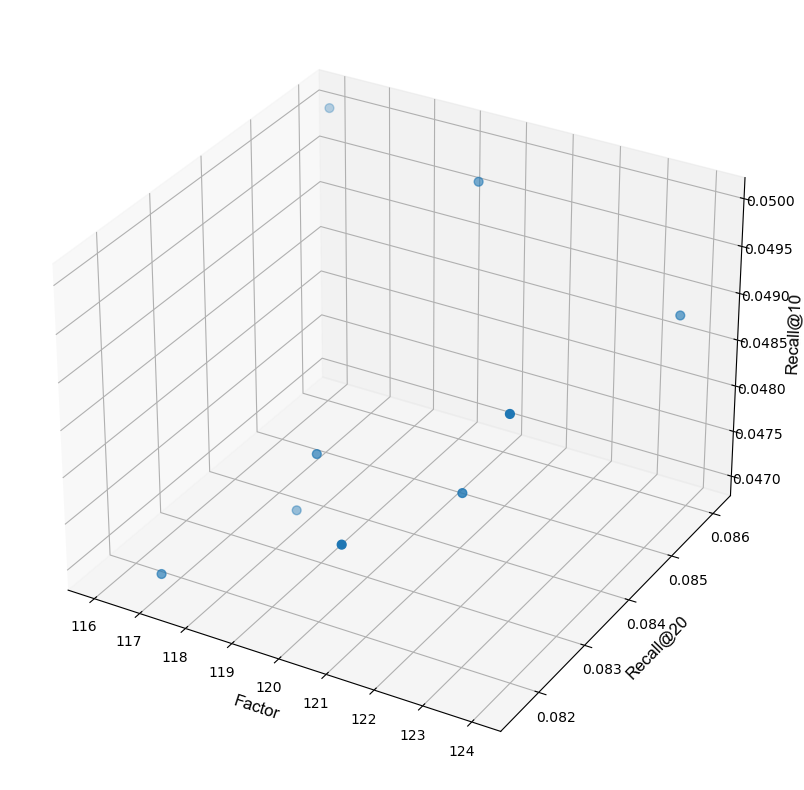

In [94]:
fig = plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 10})
ax = fig.add_subplot(projection='3d')

x, y, z = df_param4.factor, df_param4.recall_20, df_param4.recall_10
ax.set_xlabel('Factor', fontname='Arial', fontsize=12)
ax.set_zlabel('Recall@10',fontname='Arial', fontsize=12)
ax.set_ylabel('Recall@20',fontname='Arial', fontsize=12)
ax.scatter(x,y,z, cmap='viridis', marker='o', s=40)
#ax.set_title('Number of Factors in the latent Space for the NMF model', fontname='Arial', fontsize=15)
plt.show()
